In [1]:
import re

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numba import njit, prange
from scipy.optimize import LinearConstraint, minimize
from scipy.sparse.csgraph import laplacian

from graph_optimization import (fastest_averaging_constant_weight,
                                fdla_weights_symmetric, fmmc_weights,
                                generateP, lmsc_weights, max_degree_weights,
                                metropolis_hastings_weights)

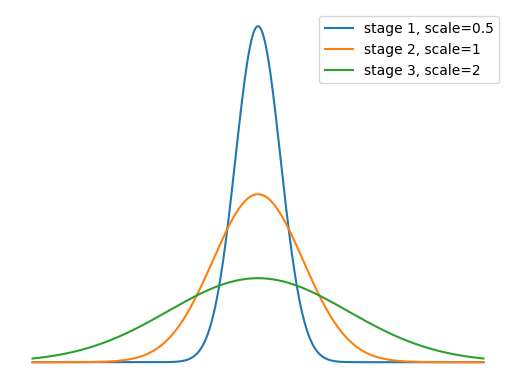

In [7]:
# create three normal distributions with mean 0 and scales 0.5, 1, 2 and plot them
x = np.linspace(-5, 5, 1000)
y1 = 1 / (np.sqrt(2 * np.pi) * 0.5) * np.exp(-0.5 * (x / 0.5) ** 2)
y2 = 1 / (np.sqrt(2 * np.pi) * 1) * np.exp(-0.5 * (x / 1) ** 2)
y3 = 1 / (np.sqrt(2 * np.pi) * 2) * np.exp(-0.5 * (x / 2) ** 2)
plt.plot(x, y1, label='stage 1, scale=0.5')
plt.plot(x, y2, label='stage 2, scale=1')
plt.plot(x, y3, label='stage 3, scale=2')
plt.legend()
plt.axis('off')
plt.show()

In [2]:
# setup
np.set_printoptions(threshold=np.inf, suppress=True, linewidth=np.inf)

In [3]:
variance = 1 # variance of the arm mean sampling distribution
real_bandit_stage = 2
num_arms = 5

In [4]:
def mat_to_vec(W):
	triu = np.triu(W, 1)
	return triu[triu != 0]

def vec_to_mat(w, A):
	W = np.zeros(A.shape)
	indices = np.argwhere(np.triu(A, 1) != 0)
	W[indices[:, 0], indices[:, 1]] = w
	W[indices[:, 1], indices[:, 0]] = w
	W[np.diag_indices(A.shape[0])] = 1 - np.sum(W, axis=1)
	W[np.abs(W) < 1e-6] = 0
	return W

In [5]:
# global weight history
weight_history = []

def coopucb2_wrapper(w, A, num_arms, bandit_stage, competencies, num_timesteps, num_runs=5000, convert_w=False, info={'Nfeval': 0}):
	if convert_w:
		P = np.zeros(A.shape)
		indices = np.argwhere(np.triu(A, 1) != 0)
		P[indices[:, 0], indices[:, 1]] = w
		P[indices[:, 1], indices[:, 0]] = w
		P[np.diag_indices(A.shape[0])] = 1 - np.sum(P, axis=1)
		P[np.abs(P) < 1e-6] = 0
	else:
		w = w.reshape(A.shape)
		w = w / np.sum(w, axis=1)[:, np.newaxis]
		P = w
	# percent_optimal_action = coopucb2(P, bandit_true_means, competencies, num_timesteps)
	percent_optimal_action = coopucb2_avg(P, num_arms, bandit_stage, competencies, num_timesteps, num_runs=num_runs)
	percent_optimal_action = np.mean(percent_optimal_action, axis=0)

	weight_history.append(P.flatten())

	if info['Nfeval'] % 100 == 0:
		print(f"{info['Nfeval']:6d}   {np.array2string(w.flatten()):150s}   {np.mean(percent_optimal_action[:, -1]):9f}")
	info['Nfeval'] += 1
	return -np.mean(percent_optimal_action[:, -1])

@njit
def coopucb2(P: np.ndarray, bandit_true_means: np.ndarray, competencies: np.ndarray, num_timesteps: int):
	# constants, hyperparameters
	num_arms = bandit_true_means.shape[0]
	num_agents, _ = P.shape

	sigma_g = 1
	eta = 2 # try 2, 2.2, 3.2
	gamma = 2.9 # try 1.9, 2.9
	f = lambda t : np.sqrt(np.log(t))
	min_variance = 1 # minimum variance for the gaussian distribution behind each arm

	# precompute constants
	G_eta = 1 - (eta ** 2) / 16
	c0 = 2 * gamma / G_eta

	# preallocate arrays
	# regret = np.zeros((num_agents, num_timesteps))
	# s_n_error = np.zeros((num_agents, num_timesteps))
	times_best_arm_selected = np.zeros((num_agents), dtype=np.int16)
	percent_optimal_action = np.zeros((num_agents, num_timesteps)) # keep track of the percentage of times the optimal action was selected by each agent
	# arm_pulled = np.zeros((num_agents, num_timesteps), dtype=np.int32)

	# estimated reward
	Q = np.zeros((num_agents, num_arms))

	# estimated means s/n
	s = np.zeros((num_agents, num_arms)) # estimated cumulative expected reward
	n = np.zeros((num_agents, num_arms)) # estimated number of times an arm has been selected by each agent

	xsi = np.zeros((num_agents, num_arms)) # number of times that arm has been selected in that timestep
	reward = np.zeros((num_agents, num_arms)) # reward vector in that timestep
	total_individual_rewards = np.zeros((num_agents)) # throughout the run

	best_arm_mean_idx = np.argmax(bandit_true_means)
	best_arm_mean = bandit_true_means[best_arm_mean_idx]

	for t in range(num_timesteps):
		last_t = t - 1 if t > 0 else 0

		if t < num_arms:
			for k in range(num_agents):
				reward[k] = np.zeros(num_arms)
				xsi[k] = np.zeros(num_arms)
				action = t

				# arm_pulled[k, t] = action
				# reward[k, action] = np.random.normal(bandit_true_means[action], min_variance)
				reward[k, action] = np.random.normal(
					bandit_true_means[action] * (competencies[k] + np.random.randn()),
					min_variance / (competencies[k] * np.abs(np.random.randn()))
				) if competencies[k] < 1 else np.random.normal(bandit_true_means[action], min_variance / competencies[k])
				total_individual_rewards[k] += reward[k, action]
				# regret[k, t] = best_arm_mean - bandit_true_means[action]
				xsi[k, action] += 1

				if action == best_arm_mean_idx:
					times_best_arm_selected[k] += 1
		else:
			for k in range(num_agents):
				for i in range(num_arms):
					true_estimate = s[k, i] / n[k, i]
					c1 = (n[k, i] + f(last_t)) / (num_agents * n[k, i])
					c2 = np.log(last_t) / n[k, i]
					confidence_bound = sigma_g * np.sqrt(c0 * c1 * c2)
					Q[k, i] = true_estimate + confidence_bound

				reward[k] = np.zeros(num_arms)
				xsi[k] = np.zeros(num_arms)

				action = np.argmax(Q[k, :])
				# arm_pulled[k, t] = action
				reward[k, action] = np.random.normal(
					bandit_true_means[action] * (competencies[k] + np.random.randn()),
					min_variance / (competencies[k] * np.abs(np.random.randn()))
				) if competencies[k] < 1 else np.random.normal(bandit_true_means[action], min_variance / competencies[k])
				total_individual_rewards[k] += reward[k, action]
				# regret[k, t] = best_arm_mean - bandit_true_means[action]
				xsi[k, action] += 1

				# s_n_error[k, t] = np.abs(best_arm_mean - (s[k, best_arm_mean_idx] / n[k, best_arm_mean_idx]))

				if action == best_arm_mean_idx:
					times_best_arm_selected[k] += 1

		percent_optimal_action[:, t] = times_best_arm_selected[:] / (t + 1)

		# update estimates using running consensus
		for i in range(num_arms):
			n[:, i] = P @ (n[:, i] + xsi[:, i])
			s[:, i] = P @ (s[:, i] + reward[:, i])

	return percent_optimal_action

@njit(parallel=True)
def coopucb2_avg(P: np.ndarray, num_arms: int, bandit_stage: int, competencies: np.ndarray, num_timesteps: int, num_runs: int = 5000):
	# constants, hyperparameters
	num_agents, _ = P.shape
	bandit_true_means = np.random.normal(0, bandit_stage, (num_runs, num_arms))

	sigma_g = 1
	eta = 2 # try 2, 2.2, 3.2
	gamma = 2.9 # try 1.9, 2.9
	f = lambda t : np.sqrt(np.log(t))
	min_variance = 1 # minimum variance for the gaussian distribution behind each arm

	# precompute constants
	G_eta = 1 - (eta ** 2) / 16
	c0 = 2 * gamma / G_eta

	# preallocate arrays
	# regret = np.zeros((num_runs, num_agents, num_timesteps))
	# s_n_error = np.zeros((num_runs, num_agents, num_timesteps))
	times_best_arm_selected = np.zeros((num_runs, num_agents), dtype=np.int16)
	percent_optimal_action = np.zeros((num_runs, num_agents, num_timesteps)) # keep track of the percentage of time the optimal action was selected by each agent
	# arm_pulled = np.zeros((num_runs, num_agents, num_timesteps), dtype=np.int32)

	for run in prange(num_runs):
		# estimated reward
		Q = np.zeros((num_agents, num_arms))

		# estimated means s/n
		s = np.zeros((num_agents, num_arms)) # estimated cumulative expected reward
		n = np.zeros((num_agents, num_arms)) # estimated number of times an arm has been selected by each agent

		xsi = np.zeros((num_agents, num_arms)) # number of times that arm has been selected in that timestep
		reward = np.zeros((num_agents, num_arms)) # reward vector in that timestep
		total_individual_rewards = np.zeros((num_agents)) # throughout the run

		# bandit = bandit_true_means[run, :] # initialize bandit
		best_arm_mean_idx = np.argmax(bandit_true_means[run, :])
		best_arm_mean = bandit_true_means[run, best_arm_mean_idx]

		for t in range(num_timesteps):
			last_t = t - 1 if t > 0 else 0

			if t < num_arms:
				for k in range(num_agents):
					reward[k] = np.zeros(num_arms)
					xsi[k] = np.zeros(num_arms)
					action = t

					# arm_pulled[run, k, t] = action
					reward[k, action] = np.random.normal(
						bandit_true_means[run, action] * (competencies[k] + np.random.randn()),
						min_variance / (competencies[k] * np.abs(np.random.randn()))
					) if competencies[k] < 1 else np.random.normal(bandit_true_means[run, action], min_variance / competencies[k])
					total_individual_rewards[k] += reward[k, action]
					xsi[k, action] += 1

					if action == best_arm_mean_idx:
						times_best_arm_selected[run, k] += 1
			else:
				for k in range(num_agents):
					for i in range(num_arms):
						true_estimate = s[k, i] / n[k, i]
						c1 = (n[k, i] + f(last_t)) / (num_agents * n[k, i])
						c2 = np.log(last_t) / n[k, i]
						confidence_bound = sigma_g * np.sqrt(c0 * c1 * c2)
						Q[k, i] = true_estimate + confidence_bound

					reward[k] = np.zeros(num_arms)
					xsi[k] = np.zeros(num_arms)

					action = np.argmax(Q[k, :])
					# arm_pulled[run, k, t] = action
					reward[k, action] = np.random.normal(
						bandit_true_means[run, action] * (competencies[k] + np.random.randn()),
						min_variance / (competencies[k] * np.abs(np.random.randn()))
					) if competencies[k] < 1 else np.random.normal(bandit_true_means[run, action], min_variance / competencies[k])
					total_individual_rewards[k] += reward[k, action]
					xsi[k, action] += 1

					if action == best_arm_mean_idx:
						times_best_arm_selected[run, k] += 1

			percent_optimal_action[run, :, t] = times_best_arm_selected[run, :] / (t + 1)

			# update estimates using running consensus
			for i in range(num_arms):
				n[:, i] = P @ (n[:, i] + xsi[:, i])
				s[:, i] = P @ (s[:, i] + reward[:, i])

	return percent_optimal_action

In [6]:
# adjacency_matrix = np.load('data/saved_networks/star_adj.npy')
# incidence_matrix = np.load('data/saved_networks/star_inc.npy')

# adjacency_matrix = np.array([
# 	[0, 1, 1],
# 	[1, 0, 1],
# 	[1, 1, 0],
# ])

# incidence_matrix = np.array([
# 	[-1, -1,  0],
# 	[ 1,  0,  1],
# 	[ 0,  1, -1],
# ])

adjacency_matrix = np.load('data/saved_networks/tadpole_adj.npy')
incidence_matrix = np.load('data/saved_networks/tadpole_inc.npy')

competencies = np.array([1, 0.5, 1, 1])

In [7]:
w, P, _ = fmmc_weights(incidence_matrix)
print(P)

[[0.54545569 0.45454431 0.         0.        ]
 [0.45454431 0.00000154 0.27272707 0.27272707]
 [0.         0.27272707 0.36893652 0.35833641]
 [0.         0.27272707 0.35833641 0.36893652]]


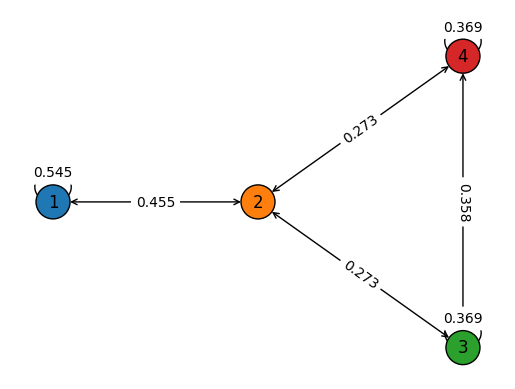

In [14]:
G = nx.from_numpy_array(np.round(P, 3))
num_agents = G.number_of_nodes()
node_labels = {i: i + 1 for i in range(num_agents)}
edge_labels = nx.get_edge_attributes(G, 'weight')
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
# pos = nx.nx_agraph.graphviz_layout(G, prog='neato')
pos = nx.spectral_layout(G)
# nx.draw(G, pos, node_color=colors, with_labels=True)
nx.draw_networkx_nodes(G, pos, edgecolors='#000000', node_color=colors, node_size=600, linewidths=1)
nx.draw_networkx_labels(G, pos, labels=node_labels)
nx.draw_networkx_edges(G, pos, edgelist=edge_labels.keys(), width=1, arrows=True, node_size=600, arrowstyle='<->')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.axis('off')
plt.savefig(f'data/img/pdf/tadpole_fmmc_stage.pdf', bbox_inches='tight')
plt.show()

In [9]:
def adjacency_to_edge_bounds(A):
	A = A + np.eye(A.shape[0])
	bounds = []
	for cell in A.flatten():
		if cell == 0:
			bounds.append((0.0, 0.0))
		else:
			bounds.append((0.0, 1.0))
	return bounds

def constraint_func(_P):
	rows = int(np.sqrt(_P.shape[0]))
	_P = _P.reshape((rows, rows))
	return np.sum(_P, axis=1) - 1

In [10]:
print(f"{'Nfeval':6s}   {'w':150s}   {'percent_optimal_action':22s}")
w, P, _ = fmmc_weights(incidence_matrix)

# result = minimize(coopucb2_wrapper, P.flatten(), args=(adjacency_matrix, num_arms, bandit_stage, competencies, 250, 1000, False), method='Powell', bounds=[(0, 1)] * 9, options={'disp': True, 'maxiter': 2000})

bounds = adjacency_to_edge_bounds(adjacency_matrix)

# constr_mat = np.zeros((adjacency_matrix.shape[0], adjacency_matrix.shape[0] ** 2))
# for i in range(adjacency_matrix.shape[0]):
# 	constr_mat[i, i * adjacency_matrix.shape[0]:(i + 1) * adjacency_matrix.shape[0]] = 1
# constr = LinearConstraint(constr_mat, np.ones(adjacency_matrix.shape[0]), np.ones(adjacency_matrix.shape[0]))

cons = {'type': 'eq', 'fun': constraint_func}

result = minimize(coopucb2_wrapper, P.flatten(), args=(adjacency_matrix, num_arms, variance, competencies, 250, 1000, False), method='Powell', bounds=bounds, constraints=cons, options={'disp': True, 'maxiter': 2000})
print(result)

Nfeval   w                                                                                                                                                        percent_optimal_action


/home/monish/Documents/GitHub/mamab-jit/venv/lib64/python3.12/site-packages/scipy/optimize/_minimize.py:576: RuntimeWarning: Method Powell cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


     0   [0.54545569 0.45454431 0.         0.         0.45454431 0.00000154 0.27272707 0.27272707 0.         0.27272707 0.36893652 0.35833641 0.         0.27272707 0.35833641 0.36893652]    0.451880
   100   [0.98958261 0.01041739 0.         0.         0.45540517 0.15986086 0.18289694 0.20183704 0.         0.27272707 0.36893652 0.35833641 0.         0.27272707 0.35833641 0.36893652]    0.687811
   200   [0.98958261 0.01041739 0.         0.         0.47078183 0.16525852 0.18907241 0.17488724 0.         0.14104034 0.61017408 0.24878558 0.         0.11429804 0.59667324 0.28902872]    0.706557
   300   [0.99771438 0.00228562 0.         0.         0.59586943 0.10259896 0.15679186 0.14473975 0.         0.13912528 0.61368229 0.24719243 0.         0.10996906 0.58638033 0.30365061]    0.745050
   400   [0.99771438 0.00228562 0.         0.         0.31909003 0.05910646 0.31035529 0.31144822 0.         0.16009162 0.42050742 0.41940096 0.         0.10996906 0.58638033 0.30365061]    0.719000
Optim

478
['(1, 1)', '(2, 1)', '(1, 2)', '(2, 2)', '(3, 2)', '(4, 2)', '(2, 3)', '(3, 3)', '(4, 3)', '(2, 4)', '(3, 4)', '(4, 4)']


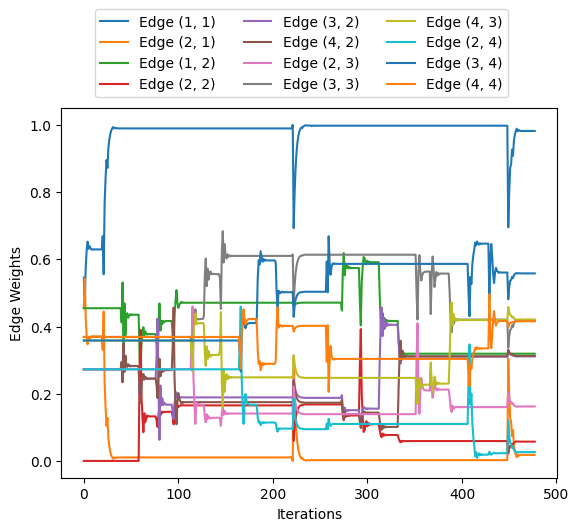

In [11]:
print(len(weight_history))
# plot each edge weight over time
# the legend should show the edge name that goes like (0, 1), (0, 2), (0, 3), (1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3) for a 3-node graph
legends = []
adjacency_with_self_loops = adjacency_matrix + np.eye(adjacency_matrix.shape[0])
for i in range(adjacency_with_self_loops.shape[0]):
	for j in range(adjacency_with_self_loops.shape[0]):
		if adjacency_with_self_loops[i, j] == 1:
			legends.append(f'({j + 1}, {i + 1})')
weight_history = np.array(weight_history)
print(legends)
fig, ax = plt.subplots()
legends_idx = 0
for i in range(weight_history.shape[1]):
	if adjacency_with_self_loops.flatten()[i] != 0:
		ax.plot(weight_history[:, i], label=f'Edge {legends[legends_idx]}')
		legends_idx += 1

ax.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', bbox_transform=fig.transFigure, ncols=3)
# plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Edge Weights')
plt.savefig(f'data/img/pdf/tadpole_weight_progress_stage_{real_bandit_stage}.pdf', bbox_inches='tight')
plt.show()

In [12]:
final_P = result.x.reshape(adjacency_matrix.shape)
final_P = final_P / np.sum(final_P, axis=1)[:, np.newaxis]
print(final_P)

[[0.98203935 0.01796065 0.         0.        ]
 [0.31909063 0.05741797 0.3111304  0.312361  ]
 [0.         0.16210106 0.41694407 0.42095487]
 [0.         0.02624433 0.55809189 0.41566378]]


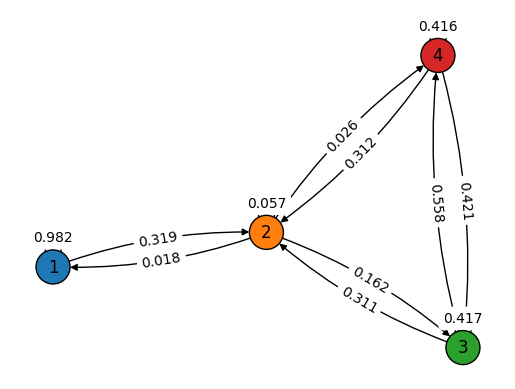

In [13]:
G = nx.MultiDiGraph(np.round(final_P, 3))
num_agents = G.number_of_nodes()
node_labels = {i: i + 1 for i in range(num_agents)}
edge_labels = nx.get_edge_attributes(G, 'weight')
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
pos = nx.nx_agraph.graphviz_layout(G, prog='neato')
# pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, edgecolors='#000000', node_color=colors, node_size=600, linewidths=1)
nx.draw_networkx_labels(G, pos, labels=node_labels)
nx.draw_networkx_edges(G, pos, edgelist=edge_labels.keys(), width=1, node_size=600, arrows = True, connectionstyle='arc3, rad = 0.1', arrowstyle='<|-')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, connectionstyle='arc3, rad = 0.1')
plt.axis('off')
plt.savefig(f'data/img/pdf/tadpole_final_P_stage_{real_bandit_stage}.pdf', bbox_inches='tight')
plt.show()